Manifold Learning:
https://www.overleaf.com/project/5eac0a8fc087300001aa3218

Available Gensim Embeddings https://github.com/RaRe-Technologies/gensim-data#datasets

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')


from gensim.models.word2vec import Word2Vec
import gensim.downloader as api
from tqdm import tqdm
import annoy
from annoy import AnnoyIndex
import random
import numpy as np
import pandas as pd
import seaborn as sns
import time
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn.manifold import spectral_embedding, MDS
from scipy.spatial.distance import squareform, pdist, cdist
from sklearn.decomposition import PCA

import numpy as np
from numba import njit, jit
from numba import types
from numba.typed import Dict
from scipy.cluster.hierarchy import linkage
from matplotlib.colors import BASE_COLORS
from helpers import mds, write_embedding_to_text_file, write_embedding_to_two_text_files, is_numeric

sns.reset_defaults()
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline



unable to import 'smart_open.gcs', disabling that module


In [2]:
# Word2Vec Dataset
from word_embedding_helpers import plot_reduced_embeddings, get_data
entity_ids, raw_embeddings, metric = get_data(num_embeddings=20000)

condensed_raw_distance_matrix = pdist(raw_embeddings, metric=metric)


In [3]:
# # DNA Simulation Dataset

# def mutate_sequence(sequence):
#     new_sequence = [s for s in sequence]
#     ix = np.random.randint(0, len(new_sequence))
#     new_sequence[ix] = np.random.choice([x for x in ["A", "C", "G", "T"] if not x == sequence[ix]])
#     return new_sequence

# def generate_mutation_chain(base_sequence, num_mutations):
#     current_sequence = base_sequence
#     chain = []
#     for i in range(num_mutations):
#         current_sequence = mutate_sequence(current_sequence)
#         chain.append(current_sequence)
#     return chain

# def sequence_distance(s1, s2):
#     return np.sum(s1 != s2) / len(s1)

# def plot_reduced_embeddings(entity_ids, reduced_embeddings):    
#     plt.figure(figsize=(10,10))
#     entity_id_to_color = {unique_entity_id: np.random.random(3) for unique_entity_id in set(entity_ids)}
#     plt.scatter(
#         x=reduced_embeddings[:,0],
#         y=reduced_embeddings[:,1],
#         c=[entity_id_to_color[i] for i in entity_ids]
#     )
#     mins = np.min(reduced_embeddings, axis=0)
#     maxs = np.max(reduced_embeddings, axis=0)
#     plt.xlim((mins[0] - abs(mins[0]*0.5), maxs[0] + abs(maxs[0]*0.5)))
#     plt.ylim((mins[1] - abs(mins[1]*0.5), maxs[1] + abs(maxs[1]*0.5)))

# num_mutations = 100
# base_sequences = np.random.choice(["A", "C", "G", "T"], (3, 50000))

# entity_ids = []
# raw_embeddings = []
# for i, b in enumerate(base_sequences):
#     entity_ids += [i for j in range(num_mutations)]
#     raw_embeddings += generate_mutation_chain(base_sequence=b, num_mutations=num_mutations)

# metric = sequence_distance

# for i, ei in enumerate(raw_embeddings):
#     for j, ej in enumerate(raw_embeddings):
#         if i != j:
#             assert ei != ej
# condensed_raw_distance_matrix = pdist(raw_embeddings, metric=metric)


In [ ]:
# Plot the spectral embeddings
def maximal_linkage_lap_from_condensed(condensed_distance_matrix):
    distance_matrix = squareform(condensed_distance_matrix)
    simplex_strength_matrix = np.exp(-distance_matrix)
    return spectral_embedding(simplex_strength_matrix, n_components=2)
#     return mds(simplex_strength_matrix, n_components=2)

maximal_linkage_lap_embeddings = maximal_linkage_lap_from_condensed(condensed_raw_distance_matrix)

plot_reduced_embeddings(entity_ids=entity_ids, reduced_embeddings=maximal_linkage_lap_embeddings)

write_embedding_to_two_text_files(
    entity_ids=entity_ids,
    embeddings=maximal_linkage_lap_embeddings,
    entity_fname="/Users/dshiebler/Downloads/maximal_linkage_laplacian_entities",
    embedding_fname="/Users/dshiebler/Downloads/maximal_linkage_laplacian_embeddings")



In [9]:

@jit(nopython=True)
def _build_distance_matrix_from_linked_helper(distance_matrix, cluster_tree, int_array=types.int64[:]):
    num_points = len(cluster_tree) + 1
    cluster_indices_to_points = Dict.empty(
        key_type=types.int64,
        value_type=int_array
    )
    for i in np.arange(num_points, dtype=np.int64):
        cluster_indices_to_points[i] = np.array([i], dtype=np.int64)
    for i in np.arange(num_points, num_points + len(cluster_tree), dtype=np.int64):
        cluster_indices_to_points[i] = np.array([np.int64(x) for x in range(0)])

    for i in range(len(cluster_tree)):
        l = cluster_tree[i]
        left_cluster = cluster_indices_to_points[int(l[0])]
        right_cluster = cluster_indices_to_points[int(l[1])]

        cluster_indices_to_points[num_points + i] = np.zeros(len(left_cluster) + len(right_cluster), dtype=np.int64)
        for il in range(len(left_cluster)):
            cluster_indices_to_points[num_points + i][il] = left_cluster[il]
        for ir in range(len(right_cluster)):
            cluster_indices_to_points[num_points + i][len(left_cluster) + ir] = right_cluster[ir]

        for left_point in left_cluster:
            for right_point in right_cluster:
                distance_matrix[left_point][right_point] = l[2]
                distance_matrix[right_point][left_point] = l[2]
    return distance_matrix, cluster_indices_to_points

def build_distance_matrix_from_linked(cluster_tree):
    distance_matrix = np.zeros((len(cluster_tree) + 1, len(cluster_tree) + 1))
    return _build_distance_matrix_from_linked_helper(distance_matrix=distance_matrix, cluster_tree=cluster_tree)


# Perform single linkage
print("Single linkage...")
cluster_tree = linkage(condensed_raw_distance_matrix)
print("Distance matrix...")
single_linkage_distance_matrix, _ = build_distance_matrix_from_linked(cluster_tree=cluster_tree)
print("Simplex strength matrix...")
single_linkage_simplex_strength_matrix = np.exp(-single_linkage_distance_matrix)



Single linkage...
Distance matrix...
Simplex strength matrix...


/usr/local/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


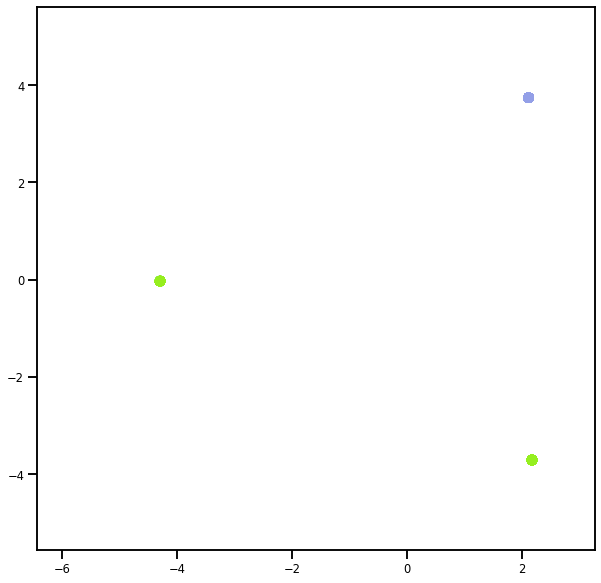

In [10]:
# Plot the spectral embeddings
# single_linkage_lap_embeddings = spectral_embedding(single_linkage_simplex_strength_matrix, n_components=2)
single_linkage_lap_embeddings = mds(single_linkage_simplex_strength_matrix, n_components=2)

plot_reduced_embeddings(entity_ids=entity_ids, reduced_embeddings=single_linkage_lap_embeddings)


write_embedding_to_two_text_files(
    entity_ids=entity_ids[:len(single_linkage_lap_embeddings)],
    embeddings=single_linkage_lap_embeddings,
    entity_fname="/Users/dshiebler/Downloads/laplacian_single_linkage_entities",
    embedding_fname="/Users/dshiebler/Downloads/laplacian_single_linkage_embeddings")

